## DDPM diffusion model implemented with 2D data 

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.datasets import make_swiss_roll

### Prepare data 
We generate the swiss roll as the true data distribution 

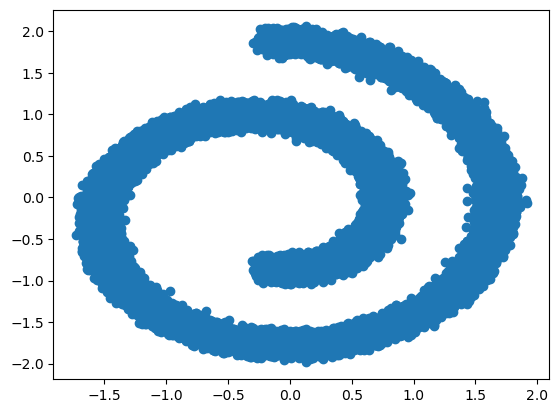

In [2]:
x,_= make_swiss_roll(n_samples=100000, noise=0.4) # noise is the extra dots that make it less like a swiss roll 
x= x[:,[0,2]]
x=  (x-x.mean())/x.std()         # normalize the x   
plt.scatter(x[:,0], x[:,1])

In [3]:
x = torch.tensor(x,dtype=torch.float32) # (100,000 , 2 ) where each row is a cartesian coordinate 
x.shape 

torch.Size([100000, 2])

#### Scheduler 
Define the \beta and \alpha values for the forward and backward process. The schedule is implemented using the cos (instead of original paper's \beta and \alpha parameters)  
- Improved DDPM uses the $\beta$ and $\alpha$ scheduler similar with flow matching's intention where the mean and variance change following the change of $\alpha$ and $\beta$.  
- Here they are the opposite: where $\beta$ goes from 0 to 1, and $\alpha$ goes from 1 to 0  
- Improved DDPM offers a much simpler way of computing $\beta$ and $\alpha$ to control the mean and variance without using $\prod$ and tricks 

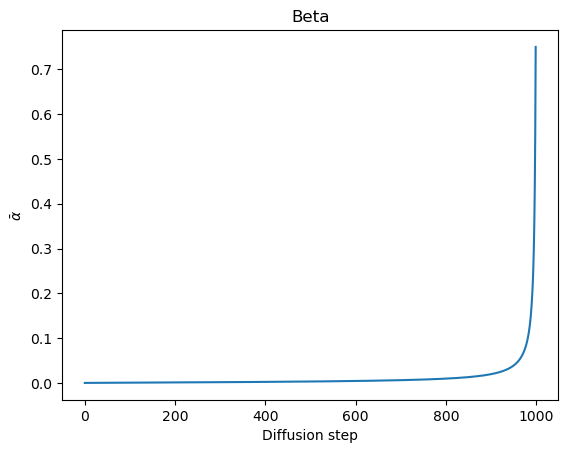

In [37]:
diffusion_steps= 1000     # t=40 
s=0.008 
timesteps= torch.tensor(range(0,diffusion_steps),dtype=torch.float32)   # make a list of time  (40,1)

# define a decreasing baralpha from 1 to close to 0 
schedule= torch.cos( (timesteps / diffusion_steps + s)  /  (1 + s) * torch.pi / 2)**2   # pairwise operation (1,40)
baralphas= schedule/schedule[0] # divide by the first term of schedule  (40,1)

# compute the beta 
# make the duplicate the first lement and replace the last one 
# beta flips the baralpha 
# normal alpha flips it back again  
betas= 1-baralphas / torch.concatenate( (baralphas[0:1], baralphas[0:-1]) ) # (40,1)
alphas= 1- betas 



sns.lineplot(betas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.title("Beta")
plt.show()

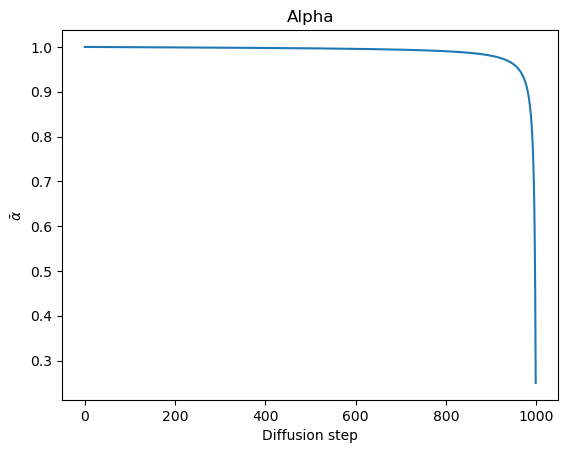

In [38]:

sns.lineplot(alphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.title("Alpha")
plt.show()

#### Forward diffusion process 
Adding a noise. We sample $\epsilon$ as a random gaussian noise. 
$X_0 = \sqrt{\text{alpha bar}} * X_t + \sqrt{\text{ 1- alpha bar}} *\epsilon $ 

In [39]:
def noise (Xbatch,t ): 
    eps= torch.randn(size=Xbatch.shape) 
    noised= (baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + ((1 - baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps 

Why do they only take the 20th index here in the forward process? 

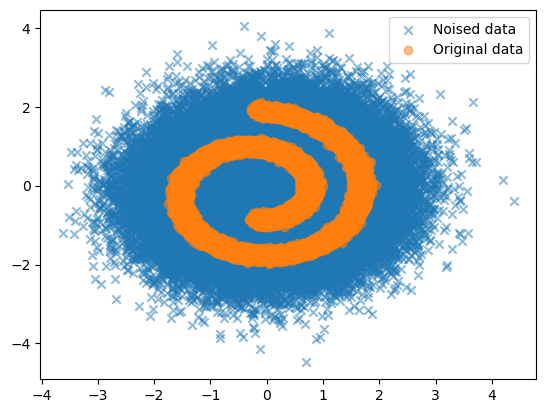

In [45]:
# denoise all the input data 
# note that here we only took the 20th index of baralpha array as the baralpha value 
noiselevel= 20 
t= torch.full([len(x),1], fill_value=noiselevel) # (100,000, 1) fill the array with noiselevel 
noised, eps= noise(x, t) 
plt.scatter(noised[:,0],noised[:,1], marker="x", alpha=0.5)
plt.scatter(x[:,0], x[:,1], alpha=0.5)
plt.legend(["Noised data", "Original data"])
plt.show() 

Denoising has a closed form solution of $$X_{t-1} = \frac{1}{\sqrt{\bar{\alpha_t}}} * (X_t - \sqrt{1-\bar{\alpha_t}} * \epsilon)$$ where $\epsilon$ is the predicted noise 

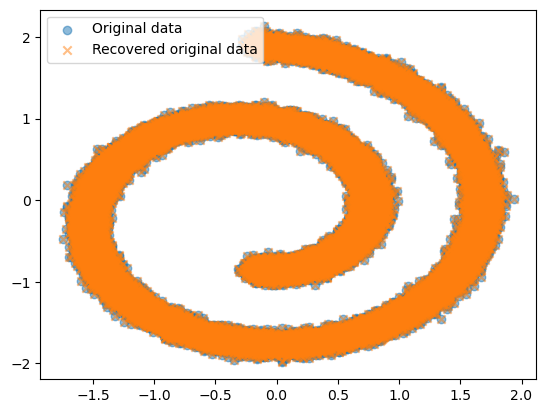

In [47]:
# because we know the noise, we can use the close form formula to get the original input back 
denoised = 1 / torch.sqrt(baralphas[noiselevel]) * (noised - torch.sqrt(1 - baralphas[noiselevel]) * eps)
plt.scatter(x[:,0], x[:,1], alpha=0.5)
plt.scatter(denoised[:,0],denoised[:,1], marker="x", alpha=0.5)
plt.legend(["Original data", "Recovered original data"])
plt.show() 

Using a diffusion model to predict the noise   
- Use the encoder and decoder structure like VAE class and U net  
 
Why add t into the model data for FC layer? 

In [7]:
import torch.nn as nn  
num_layers= 4
nunits= 64 
class DiffusionBlock (nn.Module): 
    def __init__ (self, num_layers): 
        super(DiffusionBlock,self).__init__() 
        self.linear= nn.Linear(num_layers, num_layers)  # projection of the same dimension 
    def forward(self,x):
        x= self.linear(x) 
        x= nn.functional.relu(x)    # 1 layer MLP + activation block 
        return x 
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures, num_layers, nunits): 
        super(DiffusionModel,self).__init__() 
        self.inblock= nn.Linear(nfeatures+1, nunits)    # first projection
        self.midblocks= nn.ModuleList([DiffusionBlock(nunits) for _ in range (num_layers)]) # will repeat the diffusion blocks for num_layers # of times 
        self.outblock= nn.Linear(nunits, nfeatures)
    def forward(self, x, t) -> torch.tensor: 
        val= torch.hstack([x,t])    # stack t to inputs 
        val= self.inblock(val)  
        for midblock in self.midblocks:     # looping through a set of DiffusionBlock functions 
            val= midblock(val)
        val= self.outblock (val)
        return val 

In [8]:
model = DiffusionModel(nfeatures=2, num_layers=num_layers, nunits=nunits)
model 

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-3): 4 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

Train the input data  
- Sample a random noise (noise function) with $\epsilon$ to generate a noise vector 
- sample a random time step 
- predict noise and take the L2 error   
  
- In the training process, predict the noise that is being added to the input 

In [9]:
epochs=100 
batch_size=2048 
loss_fn= nn.MSELoss() # we can use the RMSE 
optimizer= torch.optim.Adam(model.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=epochs)  # learning scheduler 
for epoch in range (epochs): 
    epoch_loss= steps=0     # steps is how many steps our model has taken in the diffusion process (which is number of times we sent in the batch)
    for i in range(0, len(x), batch_size): 
        Xbatch= x[i:i+batch_size]   # take each batch
        timesteps= torch.randint(0, diffusion_steps, size=[len(Xbatch),1])  # generate random time steps for each batch 
        noised, eps= noise(Xbatch, timesteps)
        pre = model(noised, timesteps) 
        loss= loss_fn (pre, eps)    # element wise comparison between predicted noise and the actual noise generated 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        epoch_loss+= loss 
        steps+=1 
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 1.1065499782562256
Epoch 1 loss = 0.9875338077545166
Epoch 2 loss = 0.9846248030662537
Epoch 3 loss = 0.9604589343070984
Epoch 4 loss = 0.9113205671310425
Epoch 5 loss = 0.8805941939353943
Epoch 6 loss = 0.8385905623435974
Epoch 7 loss = 0.824571430683136
Epoch 8 loss = 0.7218419313430786
Epoch 9 loss = 0.6617048382759094
Epoch 10 loss = 0.6517981290817261
Epoch 11 loss = 0.7188688516616821
Epoch 12 loss = 0.5664923191070557
Epoch 13 loss = 0.5811814665794373
Epoch 14 loss = 0.645646870136261
Epoch 15 loss = 0.5651872158050537
Epoch 16 loss = 0.5348199009895325
Epoch 17 loss = 0.5383327603340149
Epoch 18 loss = 0.6991475820541382
Epoch 19 loss = 0.5576233267784119
Epoch 20 loss = 0.5276354551315308
Epoch 21 loss = 0.5275547504425049
Epoch 22 loss = 0.5253351330757141
Epoch 23 loss = 0.5260621905326843
Epoch 24 loss = 0.5311559438705444
Epoch 25 loss = 0.5249283313751221
Epoch 26 loss = 0.5243254899978638
Epoch 27 loss = 0.5197480916976929
Epoch 28 loss = 0.52601319551467

#### Sampling
Srart with Gaussian Noise(the final distribution after T would be a normal distribution)  
  
Then predict one step before a time using the close form formula for sampling until we go back to step 0, which outputs the original paper. And this reverse sampling process is turning from the simple distribution back to the complex distribution. 

In [10]:
def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures))
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t))
            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise)
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures))
            xt += [x]
        return x, xt

In [147]:
def sample_ddim_gpt(model, nsamples, nfeatures, sample_steps, eta, betas, device):
    # precompute
    alphas = 1.0 - betas                       # shape [T]
    ᾱ = torch.cumprod(alphas, dim=0).to(device)  # shape [T]


    with torch.no_grad():
        # start from N(0,I)
        x = torch.randn(nsamples, nfeatures, device=device)

        # select timesteps
        T = alphas.shape[0]
        timesteps = torch.linspace(0, T-1, sample_steps, dtype=torch.long, device=device)
        for i in reversed(range(sample_steps)):
            t = timesteps[i]
            print(f"t: {t}")
            

            if i > 0:
                t_prev = timesteps[i-1]
                ᾱ_prev = ᾱ[t_prev]
            else:
                # at the last step, x_{−1} = x̂₀
                t_prev = None
                ᾱ_prev = torch.tensor(1.0, device=device, dtype=x.dtype)

            # scalars
            a_t = ᾱ[t]
            
            sqrt_at = a_t.sqrt()
            sqrt_omt = (1 - a_t).sqrt()

            print(f"alpha: {a_t}")
            print(f"alpha_prev: {ᾱ_prev}")
            print(f"sqrt alpha: {sqrt_at}")
            print(f"sqrt_alpha_prev: {ᾱ_prev.sqrt()}")
            print(f"Sqrt one_minus_alpha: {sqrt_omt}")

            # predict noise
            eps = model(x, torch.full([nsamples,1],t))  # or however model expects t
            print(f"predicted noise mean: {eps.mean()}")
            print(f"predicted noise std: {eps.std()}")
            # compute denoised x̂₀
            x0_pred = (x - sqrt_omt * eps) / sqrt_at
            print(f"predicted x0 mean: {x0_pred.mean()}")
            print(f"Predicted x0 std: {x0_pred.std()}")

            if i > 0:
                # compute sigma_t and the “direction” term
                sigma = eta * (
                    ((1 - ᾱ_prev) / (1 - a_t) * (1 - a_t / ᾱ_prev))
                  
                    .sqrt()
                )
                print(f'sigma: {sigma}')
                dir_term = (1 - ᾱ_prev - sigma**2).sqrt()
                print(f"Direction term: {dir_term}")
                noise = torch.randn_like(x)
                x = (ᾱ_prev).sqrt() * x0_pred + dir_term * eps + sigma * noise
            else:
                x = x0_pred
            
            print(f"new x: {x}")
            print(f"new x_t mean: {x.mean()}")
            print(f"new x_t std: {x.std()}")

    return x


In [128]:
def sample_ddim(model, nsamples, nfeatures, sample_steps, eta): 
    with torch.no_grad(): 
        x=torch.randn(nsamples,nfeatures)
        T=1000 
        sample_timesteps= torch.linspace(0,T-1,sample_steps).long() 
        alphas= 1-betas
        a_bar=torch.cumprod(alphas,dim=0)

        for i in (reversed(range(sample_steps))):
            t= sample_timesteps[i] 
            t_prev= sample_timesteps[i-1] if i>0 else torch.tensor([-1])
            t_tensor= torch.full([nsamples,1],t)
            

            ab_t_prev=a_bar[t_prev] if i>0 else torch.tensor(1.0)
            ab= a_bar[t]

            print(f"t: {t}")
            sqrt_ab = ab.sqrt() 
            sqrt_ab_t_prev= ab_t_prev.sqrt()
            sqrt_one_minus_t= (1-ab).sqrt()  

            pred_noise= model(x,t_tensor)
            
            
            x0_t= (x- (sqrt_one_minus_t *pred_noise)) /sqrt_ab

            sigma_t= ( (1-ab_t_prev) / (1-ab) * (1-ab/ab_t_prev)).sqrt() * eta
            
            direction_term= (1-ab_t_prev-sigma_t**2).sqrt()

            
            noise= torch.randn_like(x)
            if i>0: 
                x= sqrt_ab_t_prev * x0_t + direction_term*pred_noise + sigma_t*noise
            else: 
                x= x0_t 

            print(f"new x: {x}")

    return x 


In [148]:
x_gen= sample_ddim_gpt(model, 10000,2,250, eta=0.7, betas=betas,device="cpu")
#x_gen= sample_ddim(model, 10000,2,250, eta=0.7)

t: 999
alpha: 2.428921561659081e-06
alpha_prev: 8.743387297727168e-05
sqrt alpha: 0.0015584997599944472
sqrt_alpha_prev: 0.009350608102977276
Sqrt one_minus_alpha: 0.9999987483024597
predicted noise mean: -0.09574452042579651
predicted noise std: 0.9718881249427795
predicted x0 mean: 54.466487884521484
Predicted x0 std: 44.443328857421875
sigma: 0.6901791095733643
Direction term: 0.723578155040741
new x: tensor([[-1.6273, -0.8828],
        [ 1.3391,  1.9624],
        [ 0.3731,  0.3552],
        ...,
        [-0.2380,  0.6178],
        [ 3.2751,  0.3197],
        [ 1.5372,  1.2183]])
new x_t mean: 0.4439237415790558
new x_t std: 1.1264867782592773
t: 994
alpha: 8.743387297727168e-05
alpha_prev: 0.0002428552252240479
sqrt alpha: 0.009350608102977276
sqrt_alpha_prev: 0.015583813190460205
Sqrt one_minus_alpha: 0.9999562501907349
predicted noise mean: 0.3307029902935028
predicted noise std: 1.0733861923217773
predicted x0 mean: 12.109928131103516
Predicted x0 std: 10.658458709716797
sigma: 

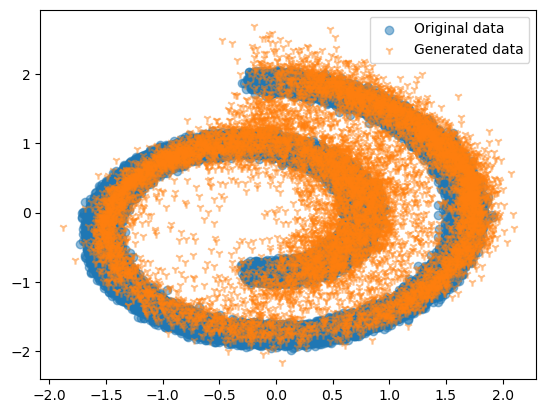

In [146]:
plt.scatter(x[:, 0], x[:, 1], alpha=0.5)
plt.scatter(x_gen[:, 0], x_gen[:, 1], marker="1", alpha=0.5)
plt.legend(["Original data", "Generated data"])
plt.show()

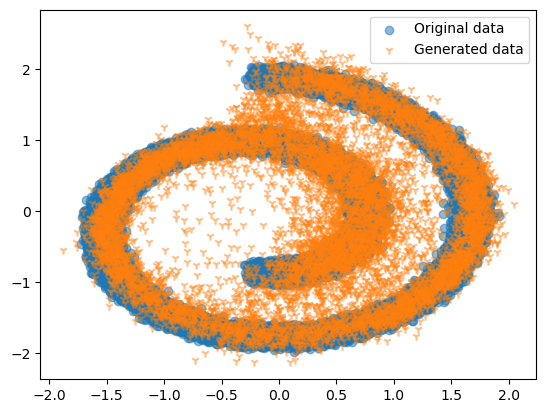

In [27]:
Xgen, Xgen_hist = sample_ddpm(model, 10000, 2)
Xgen = Xgen.cpu()
plt.scatter(x[:, 0], x[:, 1], alpha=0.5)
plt.scatter(Xgen[:, 0], Xgen[:, 1], marker="1", alpha=0.5)
plt.legend(["Original data", "Generated data"])
plt.show()